### Predicting real estate prices in Launceston, TAS - Does weather and temperature have an influence?

#### Column Descriptions:
- 'date of sale': Date when the property was officially sold.
- 'bedrooms': Number of bedrooms in the property.
- 'bathrooms': Number of bathrooms in the property.
- 'car spaces': Number of car spaces allocated to the property.
- 'land size': Size of the land in square meters associated with the property.
- 'price': Selling price of the property in AUD.  
- 'tavg': Average temperature on the date of sale.
- 'tmin': Minimum temperature on the date of sale.
- 'tmax': Maximum temperature on the date of sale.
- 'avg_tavg_7_days': Average temperature over the 7 days leading up to the sale date.
- 'avg_tmin_7_days': Minimum temperature over the 7 days leading up to the sale date.
- 'avg_tmax_7_days': Maximum temperature over the 7 days leading up to the sale date.
- 'avg_tavg_30_days': Average temperature over the 30 days leading up to the sale date.
- 'avg_tmin_30_days': Minimum temperature over the 30 days leading up to the sale date.
- 'avg_tmax_30_days': Maximum temperature over the 30 days leading up to the sale date.  
- 'price_smoothed': Smoothed curve obtained through rolling average of the property prices.
- 'price_index': Index reflecting general price changes based on the smoothed price, with the initial date set as 1.
- 'price_adjusted': Property price adjusted for general price changes using the price index.
- 'land size_log': Natural logarithm of the land size.
- 'price_adjusted_log': Natural logarithm of the adjusted property price.
- 'tavg_PC': Principal component derived from the average temperature on the sale date and preceding 7 and 30 days.


In [1]:
# Import necessary packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter, MaxNLocator
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
# Read the CSV file into a pandas DataFrame
df = pd.read_csv('merged_real_estate_and_weather_data.csv')

## Data Exploration

In [3]:
# Convert 'date of sale' column to datetime and set as index
df['date of sale'] = pd.to_datetime(df['date of sale'], format='%Y-%m-%d')
df = df.set_index('date of sale')

# Sort the DataFrame by the date column
df = df.sort_values(by='date of sale')

In [4]:
# Convert suitable columns to numeric
numeric_cols = df.select_dtypes(include=['object']).columns
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Create a summary of all columns
summary = df.describe()

# Display the summary
summary

,bedrooms,bathrooms,car spaces,land size,price,tavg,tmin,tmax,avg_tavg_7_days,avg_tmin_7_days,avg_tmax_7_days,avg_tavg_30_days,avg_tmin_30_days,avg_tmax_30_days
count,523.000000,523.000000,523.000000,523.000000,5.230000e+02,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000
mean,3.042065,1.600382,1.307839,551.458891,4.889085e+05,12.185660,7.675526,18.998088,12.200574,7.808031,19.000000,12.277438,7.827916,19.131931
std,0.959999,0.736929,1.101582,1000.515340,2.517570e+05,4.643052,5.021972,5.187894,4.153577,4.207853,4.601545,3.976953,3.871680,4.438847
min,1.000000,1.000000,0.000000,18.000000,1.200000e+05,1.900000,-3.100000,7.900000,3.800000,-1.300000,10.900000,5.500000,0.200000,11.800000
25%,2.000000,1.000000,1.000000,237.000000,3.077500e+05,8.550000,3.900000,14.500000,8.750000,4.650000,15.000000,8.900000,4.400000,15.100000
50%,3.000000,1.000000,1.000000,400.000000,4.200000e+05,12.200000,7.900000,19.000000,12.300000,8.100000,19.000000,12.300000,7.900000,19.100000
75%,4.000000,2.000000,2.000000,580.500000,6.162500e+05,15.550000,11.350000,22.700000,15.500000,11.000000,22.500000,15.850000,11.300000,23.300000
max,7.000000,6.000000,7.000000,13000.000000,1.450000e+06,25.700000,19.400000,34.600000,22.200000,16.300000,32.000000,20.200000,15.100000,27.800000


## Exploring Prices and Correcting for Long-Term Trend

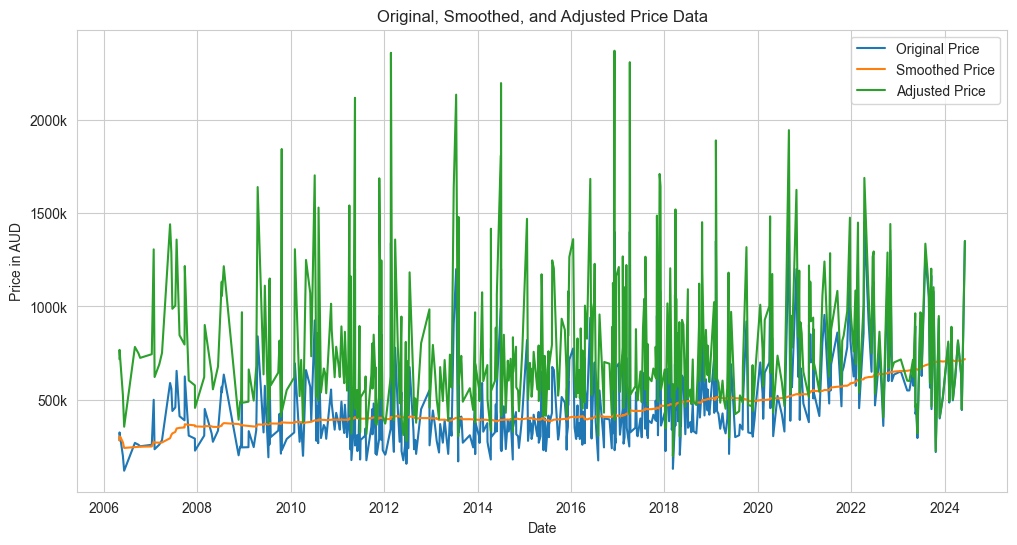

In [5]:
# Calculate the moving average with a window size of 100
df['price_smoothed'] = df['price'].rolling(window=100, min_periods=1).mean()

# Create a price index based on the smoothed curve with an end point of 1
df['price_index'] = (df['price_smoothed'] / df['price_smoothed'].iloc[-1])

# Adjust the prices by dividing them by the price index
df['price_adjusted'] = df['price'] / df['price_index']


# Function to format y-axis labels in thousands
def thousands(x, pos):
    return f'{x / 1000:.0f}k'


# Set seaborn style to whitegrid
sns.set_style("whitegrid")

# Plot the original, smoothed, and adjusted prices with y-axis in thousands
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['price'], label='Original Price')
plt.plot(df.index, df['price_smoothed'], label='Smoothed Price')
plt.plot(df.index, df['price_adjusted'], label='Adjusted Price')
plt.xlabel('Date')
plt.ylabel('Price in AUD')
plt.title('Original, Smoothed, and Adjusted Price Data')
plt.legend()
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands))  # Format y-axis labels in thousands
plt.show()

## Exploring Temperature Data

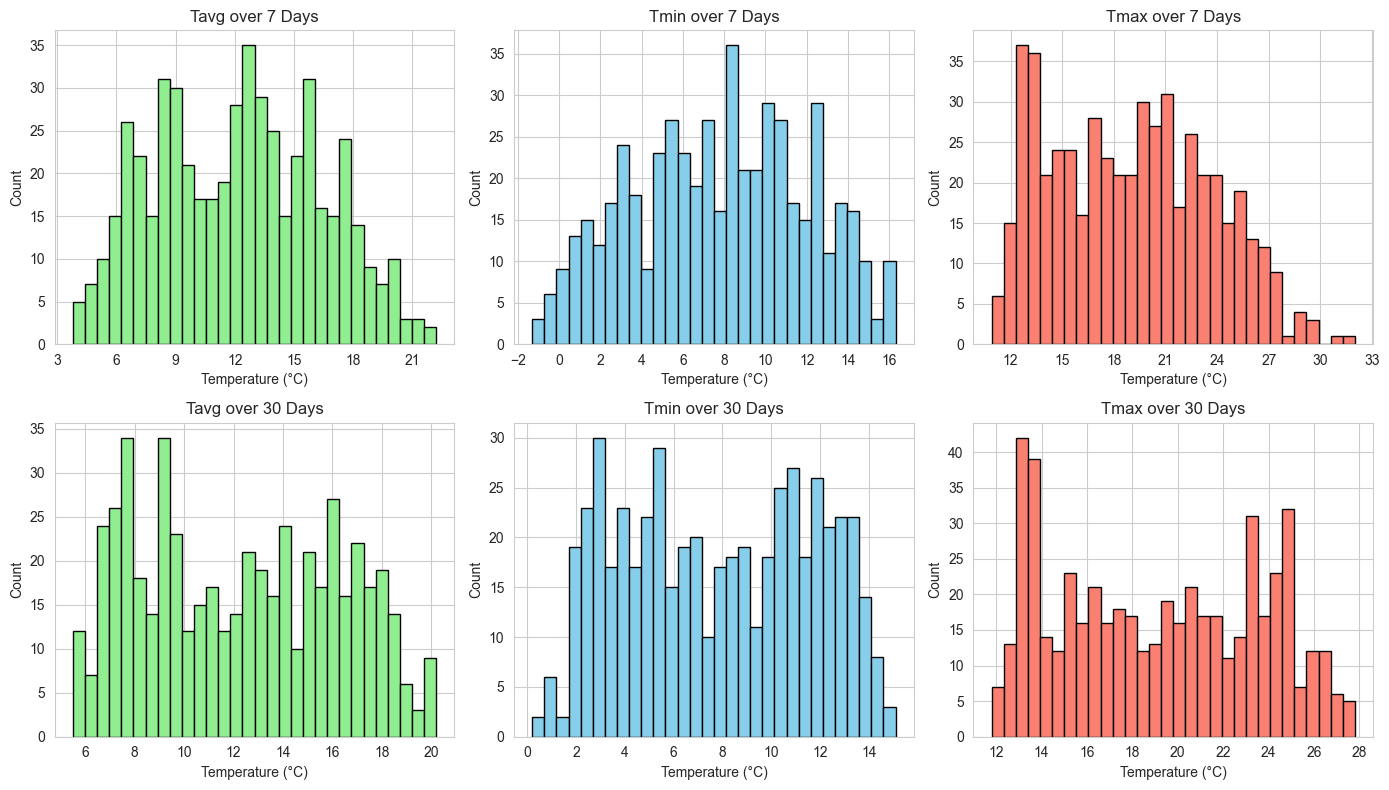

In [6]:
# Columns to plot
columns_to_plot = ['avg_tavg_7_days', 'avg_tmin_7_days', 'avg_tmax_7_days', 'avg_tavg_30_days', 'avg_tmin_30_days',
                   'avg_tmax_30_days']

# Create a 2x3 subplot for histograms
fig, axs = plt.subplots(2, 3, figsize=(14, 8))

# Define colors for different columns
colors = ['lightgreen', 'skyblue', 'salmon']

# Iterate over columns and plot histograms with different colors
for i, column in enumerate(columns_to_plot):
    row = i // 3
    col = i % 3
    color_index = col  # Assign colors based on column index
    axs[row, col].hist(df[column], bins=30, color=colors[color_index], edgecolor='black')
    axs[row, col].set_xlabel('Temperature (°C)')
    axs[row, col].set_ylabel('Count')
    title_parts = column.split('_')
    title = f"{title_parts[1].capitalize()} over {(title_parts[2] + title_parts[3]).replace('days', ' Days')}"
    axs[row, col].set_title(title)
    axs[row, col].xaxis.set_major_locator(MaxNLocator(integer=True))  # Set x-axis ticks to integers

plt.tight_layout()
plt.show()

## Exploring Property Data

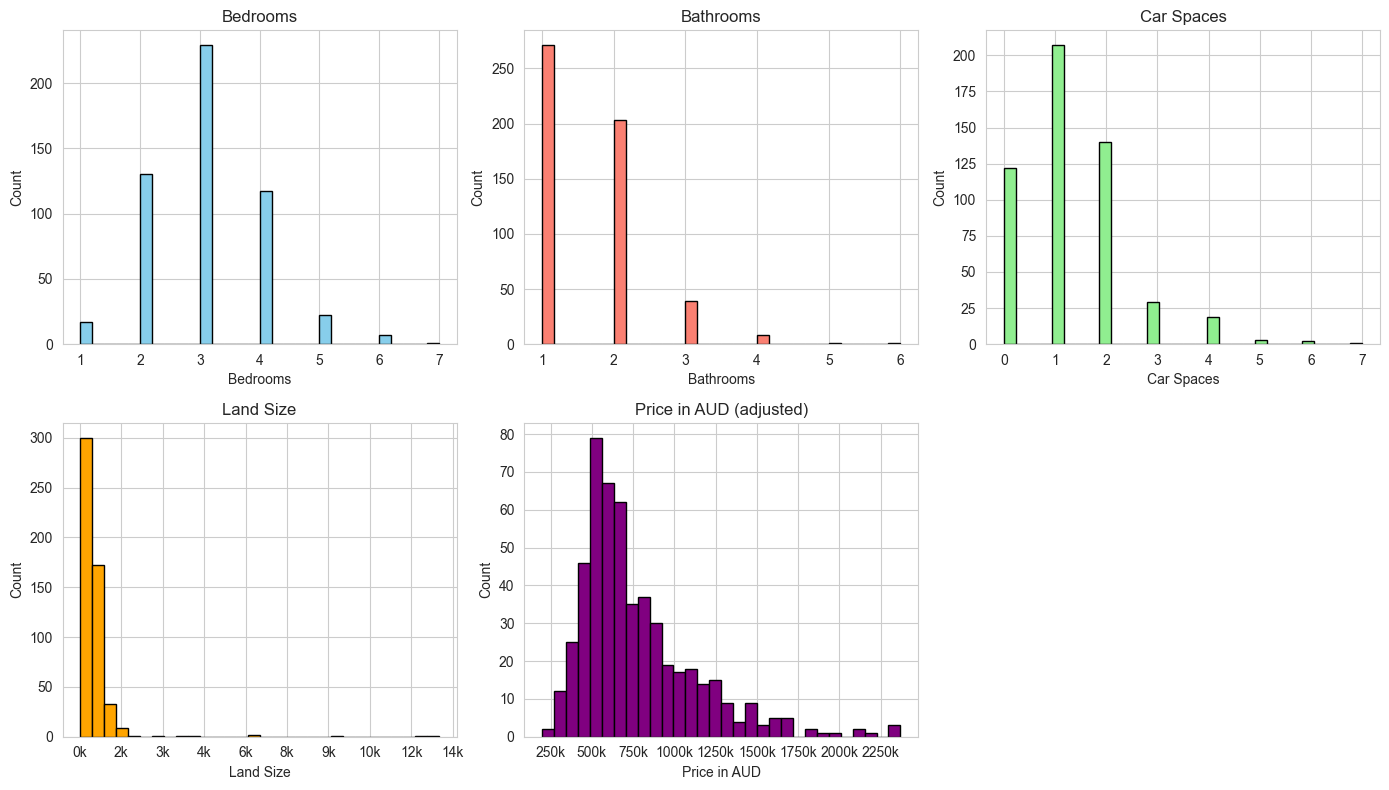

In [8]:
# Columns to plot
columns_to_plot = ['bedrooms', 'bathrooms', 'car spaces', 'land size', 'price_adjusted']

# Define colors for each column
colors = ['skyblue', 'salmon', 'lightgreen', 'orange', 'purple']

# Create a 2x3 subplot for histograms
fig, axs = plt.subplots(2, 3, figsize=(14, 8))

# Iterate over columns and plot histograms with different colors
for i, column in enumerate(columns_to_plot):
    row = i // 3
    col = i % 3
    axs[row, col].hist(df[column], bins=30, color=colors[i], edgecolor='black')
    axs[row, col].set_xlabel(' '.join(word.capitalize() for word in column.split()))
    axs[row, col].set_ylabel('Count')
    title = column.replace(' ', ' ').title()
    axs[row, col].set_title(title)
    axs[row, col].xaxis.set_major_locator(MaxNLocator(integer=True))  # Set x-axis ticks to integers

    # Format x-axis labels for 'Land Size' and 'Price_Adjusted'
    if column == 'land size' or column == 'price_adjusted':
        axs[row, col].xaxis.set_major_formatter(FuncFormatter(thousands))

    # Update title and x-axis label for 'Price_Adjusted'
    if column == 'price_adjusted':
        axs[row, col].set_title('Price in AUD (adjusted)')
        axs[row, col].set_xlabel('Price in AUD')

# Remove the last subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

## Adjusting and Transforming Features

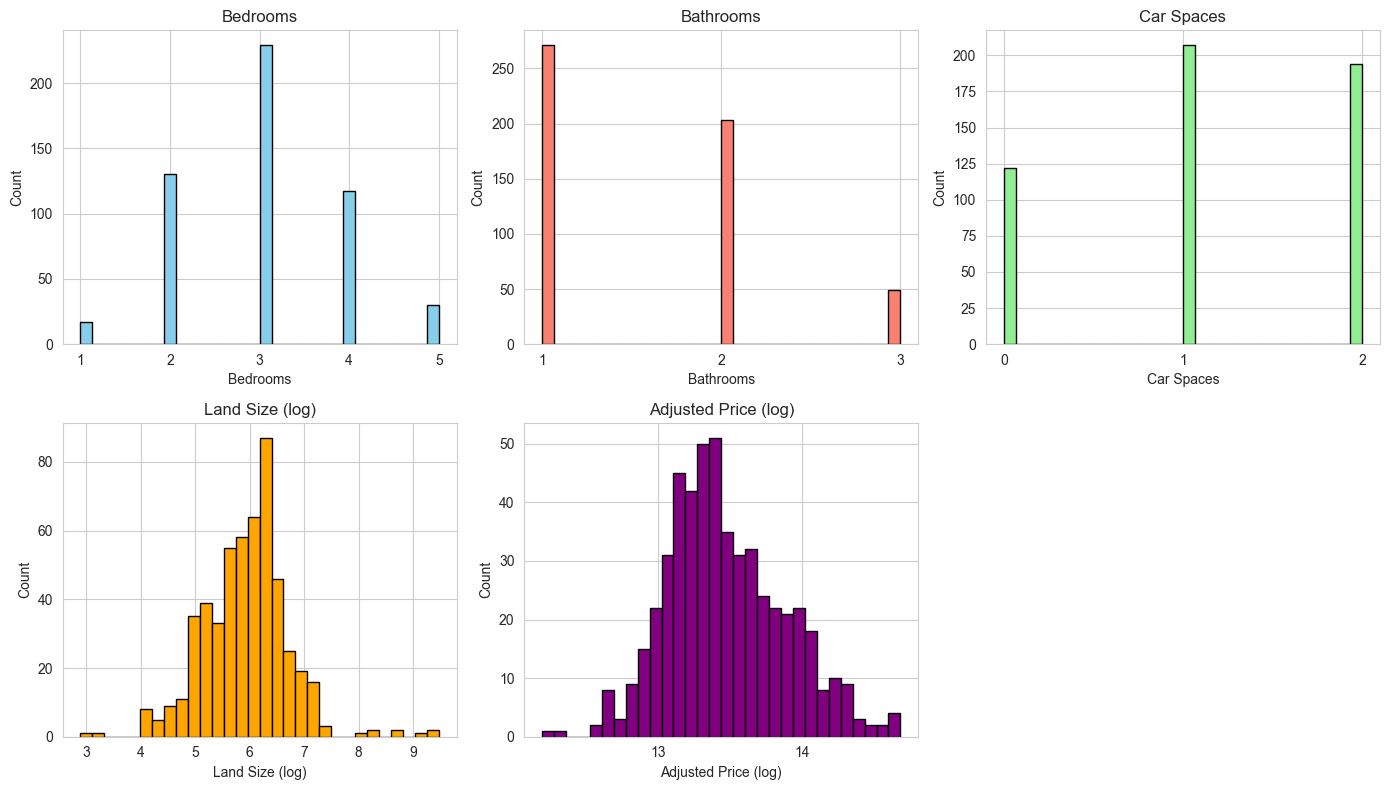

In [16]:
# Remap values in the 'bedrooms', 'bathrooms', and 'car spaces' columns
df['bedrooms'] = df['bedrooms'].apply(lambda x: 5 if x >= 5 else x)
df['bathrooms'] = df['bathrooms'].apply(lambda x: 3 if x >= 3 else x)
df['car spaces'] = df['car spaces'].apply(lambda x: 2 if x >= 2 else x)

# Apply natural logarithm transformation to 'land size' and 'price' columns
df['land size_log'] = np.log(df['land size'])
df['price_adjusted_log'] = np.log(df['price_adjusted'])

# Columns to plot
columns_to_plot = ['bedrooms', 'bathrooms', 'car spaces', 'land size_log', 'price_adjusted_log']

# Create a 2x3 subplot for histograms
fig, axs = plt.subplots(2, 3, figsize=(14, 8))

# Iterate over columns and plot histograms with different colors
for i, column in enumerate(columns_to_plot):
    row = i // 3
    col = i % 3
    axs[row, col].hist(df[column], bins=30, color=colors[i], edgecolor='black')
    axs[row, col].set_ylabel('Count')

    # Update title and x-axis label for 'land size_log' and 'price_adjusted_log'
    if column == 'land size_log':
        axs[row, col].set_xlabel('Land Size (log)')
        axs[row, col].set_title('Land Size (log)')
    elif column == 'price_adjusted_log':
        axs[row, col].set_xlabel('Adjusted Price (log)')
        axs[row, col].set_title('Adjusted Price (log)')
    else:
        axs[row, col].set_xlabel(' '.join(word.capitalize() for word in column.split()))
        title = column.replace(' ', ' ').title()
        axs[row, col].set_title(title)

    axs[row, col].xaxis.set_major_locator(MaxNLocator(integer=True))  # Set x-axis ticks to integers

# Remove the last subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

## Plotting Correlations and Exploring Relationships

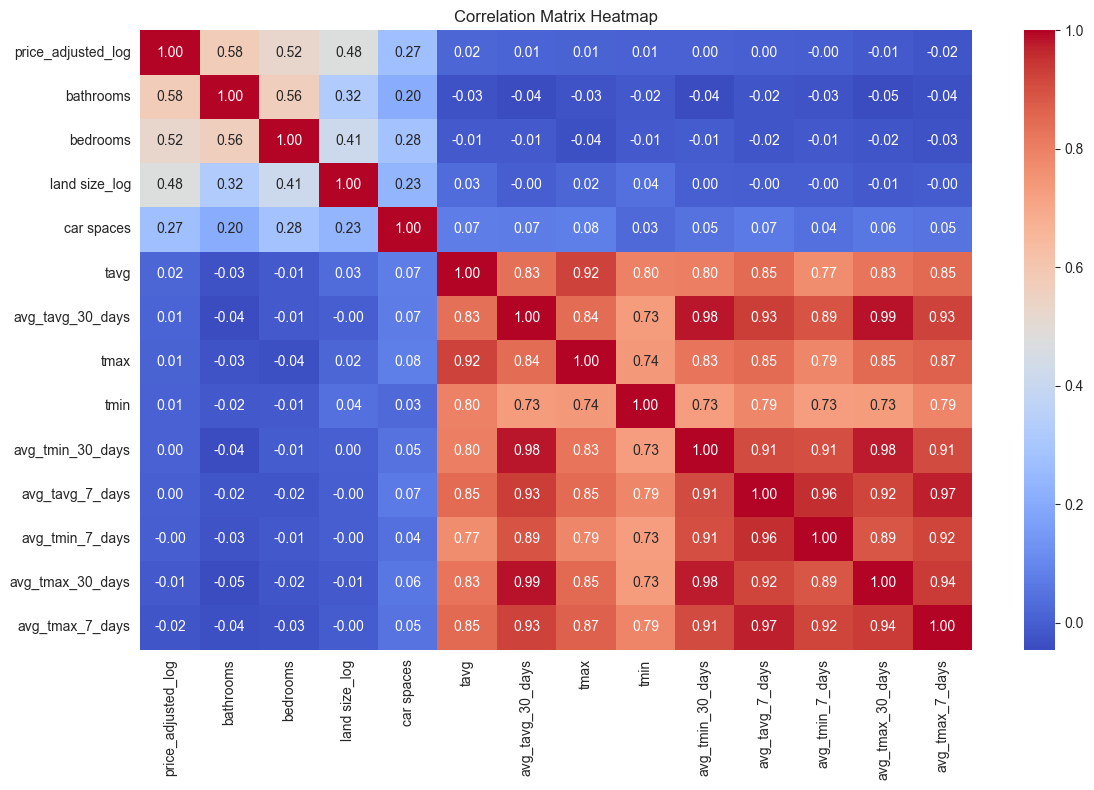

In [17]:
# Select the specific columns for the correlation heatmap
selected_columns = ['bedrooms', 'bathrooms', 'car spaces', 'tavg', 'tmin', 'tmax',
                    'avg_tavg_7_days', 'avg_tmin_7_days', 'avg_tmax_7_days',
                    'avg_tavg_30_days', 'avg_tmin_30_days', 'avg_tmax_30_days',
                    'land size_log', 'price_adjusted_log']

# Subset the DataFrame with the selected columns
df_selected = df[selected_columns]

# Calculate the correlation matrix
corr = df_selected.corr()

# Reorder the correlation matrix with 'price' at the top
corr_price_adjusted_log = corr['price_adjusted_log'].sort_values(ascending=False)
corr = corr.reindex(index=corr_price_adjusted_log.index, columns=corr_price_adjusted_log.index)

# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')

plt.tight_layout()
plt.show()

## Feature Creation - Reducing Temperature Data

In [18]:
# Select the columns for PCA
columns_for_pca = ['tavg', 'avg_tmax_7_days', 'avg_tavg_30_days']

# Subset the DataFrame with the selected columns
df_pca = df[columns_for_pca]

# Standardize the data
scaler = StandardScaler()
df_pca_scaled = scaler.fit_transform(df_pca)

# Perform PCA to extract one principal component
pca = PCA(n_components=1)
principal_components = pca.fit_transform(df_pca_scaled)

# Add the principal component values to the original DataFrame
df['tavg_PC'] = principal_components

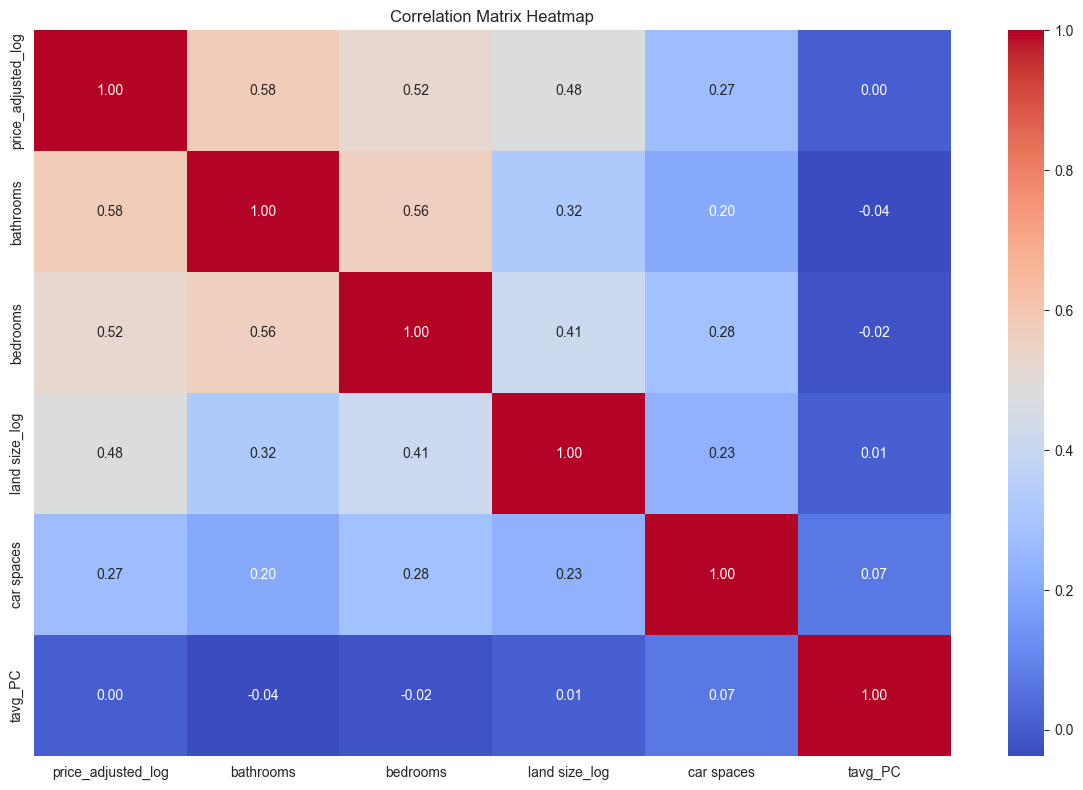

In [19]:
# Select the specific columns for the correlation heatmap
selected_columns = ['bedrooms', 'bathrooms', 'car spaces', 'tavg_PC', 'land size_log', 'price_adjusted_log']

# Subset the DataFrame with the selected columns
df_selected = df[selected_columns]

# Calculate the correlation matrix
corr = df_selected.corr()

# Reorder the correlation matrix with 'price' at the top
corr_price_adjusted_log = corr['price_adjusted_log'].sort_values(ascending=False)
corr = corr.reindex(index=corr_price_adjusted_log.index, columns=corr_price_adjusted_log.index)

# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')

plt.tight_layout()
plt.show()

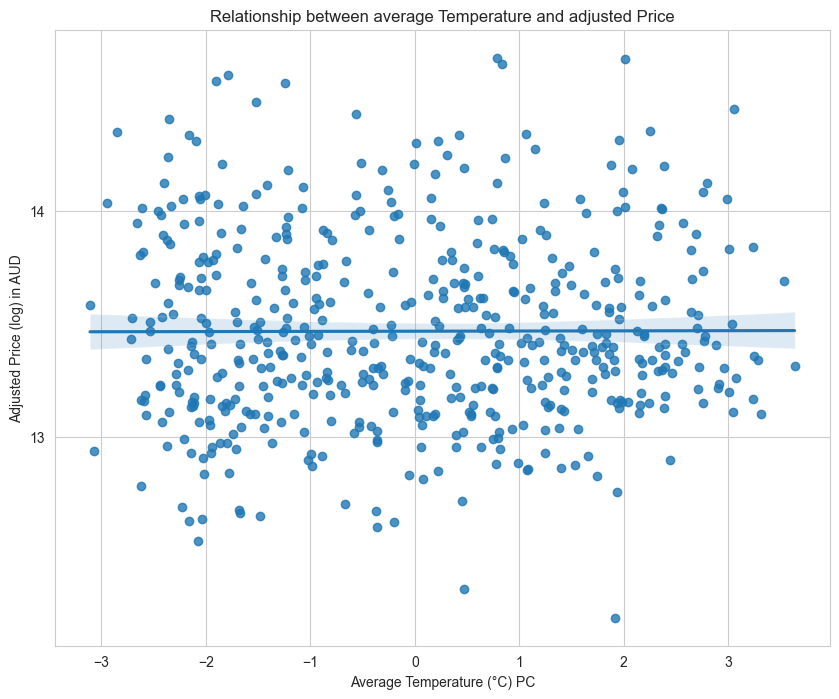

In [20]:
# Create a scatter plot with regression line using Seaborn
plt.figure(figsize=(10, 8))
sns.regplot(x='tavg_PC', y='price_adjusted_log', data=df)
plt.xlabel('Average Temperature (°C) PC')
plt.ylabel('Adjusted Price (log) in AUD')
plt.title('Relationship between average Temperature and adjusted Price')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))  # Format x-axis labels to integers
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))  # Format y-axis labels to integers
plt.show()

## Feature Selection for Estimation Model

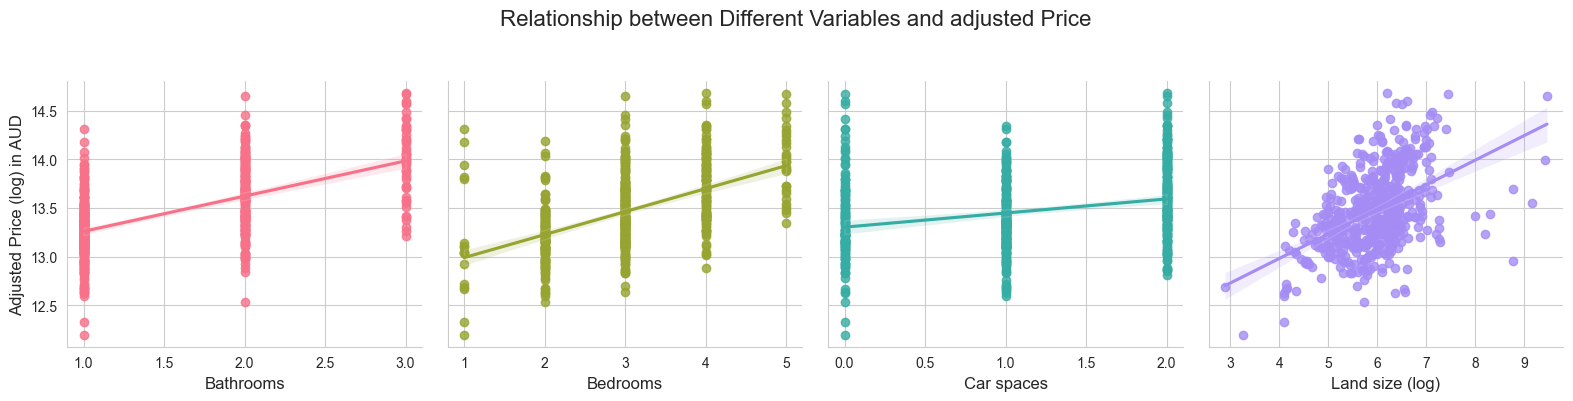

In [26]:
# Define the columns for the scatter plots
columns_to_plot = ['bathrooms', 'bedrooms', 'car spaces', 'land size_log']

# Set a custom color palette for the plots
custom_palette = sns.color_palette("husl", len(columns_to_plot))

# Create a PairGrid for the scatter plots with improved styling
g = sns.PairGrid(df, x_vars=columns_to_plot, y_vars=['price_adjusted_log'], height=4)

# Set custom colors for each plot and format x-axis labels
for i, ax in enumerate(g.axes.flat):
    sns.regplot(x=df[columns_to_plot[i]], y=df['price_adjusted_log'], color=custom_palette[i], ax=ax)
    x_label = ' '.join(word.capitalize() if word != 'log' else '(log)' for word in columns_to_plot[i].split('_'))
    ax.set_xlabel(x_label, fontsize=12)

# Set axis labels and titles
for ax in g.axes.flat:
    ax.set_ylabel('Adjusted Price (log) in AUD', fontsize=12)

# Adjust the layout and style
g.fig.suptitle('Relationship between Different Variables and adjusted Price', fontsize=16)

# Adjust the spacing between the plots and the super title
plt.subplots_adjust(top=0.8)

plt.show()

## Model Building 

In [27]:
# Define the predictors and criterion
predictors = ['bathrooms', 'land size_log', 'bedrooms']
criterion = 'price_adjusted_log'

# Split the data into predictors (X) and criterion (y)
X = df[predictors]
y = df[criterion]

# Create a StandardScaler and LinearRegression pipeline
model = make_pipeline(StandardScaler(), LinearRegression())

# Initialize arrays to store the coefficients and scores from each fold
coefficients = np.zeros((4, len(predictors)))
r2_scores = []
mse_scores = []
kf = KFold(n_splits=4, shuffle=True, random_state=8)

# Perform 4-fold cross-validation and store the coefficients and scores
for train_index, test_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    coefficients[i] = model.named_steps['linearregression'].coef_

    y_pred = model.predict(X_val)
    r2 = r2_score(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)

    r2_scores.append(round(r2, 2))
    mse_scores.append(round(mse, 2))

# Calculate the average coefficients
average_coefficients = np.mean(coefficients, axis=0)

# Create a consolidated model using the average coefficients
consolidated_model = LinearRegression()
consolidated_model.coef_ = average_coefficients

# Fit the consolidated model on the entire dataset
consolidated_model.fit(X, y)

# Evaluate the model statistics on the entire dataset
y_pred = consolidated_model.predict(X)
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)

# Print the model statistics
print("Model Statistics:")
print(f"R^2 Score: {round(r2, 2)}")
print(f"Mean Squared Error: {round(mse, 2)}")
print(f"K-Fold R^2 Scores: {r2_scores}")
print(f"K-Fold Mean Squared Errors: {mse_scores}")

# Predict all values from the dataset using the consolidated model
y_pred_all = consolidated_model.predict(X)

Model Statistics:
R^2 Score: 0.45
Mean Squared Error: 0.09
K-Fold R^2 Scores: [0.43, 0.39, 0.47, 0.43]
K-Fold Mean Squared Errors: [0.11, 0.1, 0.09, 0.08]


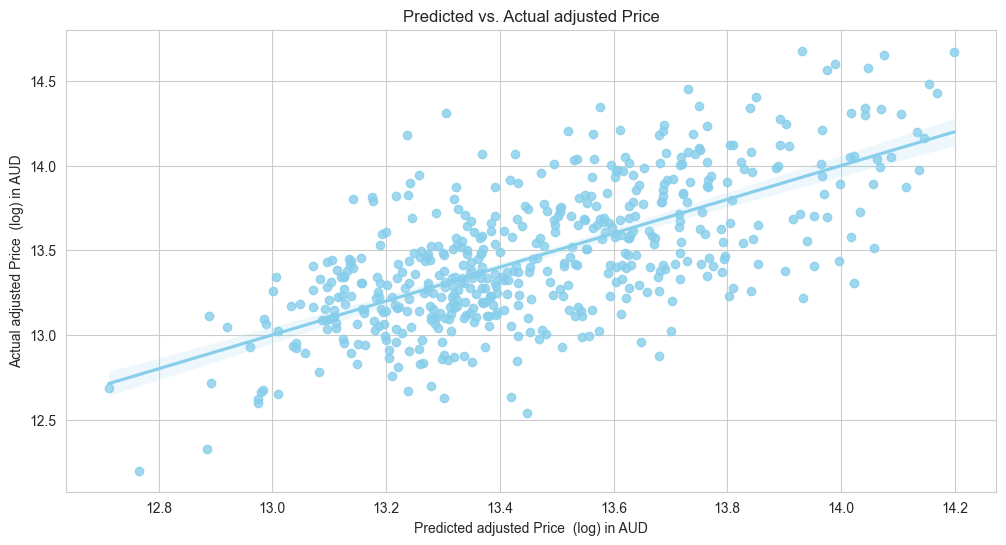

In [28]:
# Create a scatter plot of predicted vs. actual values
plt.figure(figsize=(12, 6))
sns.regplot(x=y_pred_all, y=y, color='skyblue')
plt.xlabel('Predicted adjusted Price  (log) in AUD')
plt.ylabel('Actual adjusted Price  (log) in AUD')
plt.title('Predicted vs. Actual adjusted Price')
plt.show()

In [29]:
# Extract the coefficients from the consolidated model
intercept = consolidated_model.intercept_
coefficients = consolidated_model.coef_

# Create the regression formula
regression_formula = f"Predicted adjusted Price (log) = {intercept:.2f} "
for i, predictor in enumerate(predictors):
    regression_formula += f"+ {coefficients[i]:.2f} * {predictor} "

# Print the regression formula
print("Regression Formula:")
print(regression_formula)

Regression Formula:
Predicted adjusted Price (log) = 11.97 + 0.24 * bathrooms + 0.14 * land size_log + 0.09 * bedrooms 


In [36]:
# Create the directly usable regression formula
regression_formula_usable = f"Predicted Price = e^({intercept:.2f} "

for i, predictor in enumerate(predictors):
    if predictor != 'land size_log':
        regression_formula_usable += f"+ {coefficients[i]:.2f} * {predictor}"
    else:
        regression_formula_usable += f" + {coefficients[i]:.2f} * ln(land size) "

regression_formula_usable += ')'

# Print the regression formula
print("Usable Regression Formula:")
print(regression_formula_usable)

Usable Regression Formula:
Predicted Price = e^(11.97 + 0.24 * bathrooms + 0.14 * ln(land size) + 0.09 * bedrooms)


## Export Data for BI Dashboard

In [39]:
# List of important columns for the dashboard dataframe
dashboard_columns = ['bathrooms', 'bedrooms', 'land size_log', 'land size', 'price_adjusted_log',
                     'price_adjusted']

# Create the dashboard dataframe by selecting the important columns from the original dataframe
df_dashboard = df[dashboard_columns].copy()

# Data for the model information dataframe
model_info = {
    'r2 score': [round(r2, 2)],
    'intercept': [intercept]
}

# Loop through predictors and coefficients to create columns in the model information dataframe
for i, predictor in enumerate(predictors):
    model_info[predictor] = [coefficients[i]]

df_model_info = pd.DataFrame(model_info)

# Save the dataframes to Excel files
with pd.ExcelWriter('Dashboard.xlsx') as writer:
    df_dashboard.to_excel(writer, sheet_name='Dashboard Data', index=False)
    df_model_info.to_excel(writer, sheet_name='Model Info', index=False)